# 04 - Ensemble & Calibration

**Objectif** : Combiner Dixon-Coles + ELO et verifier la calibration des probabilites.

## Questions cles :
1. L'ensemble est-il meilleur que chaque modele seul ?
2. Les probabilites sont-elles calibrees (70% predit = 70% reel) ?
3. Quels poids optimaux pour l'ensemble ?

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.models.dixon_coles import DixonColesModel, MatchResult
from src.models.elo import EloRating, EloMatch
from src.models.ensemble import EnsemblePredictor
from src.evaluation.calibration import evaluate, brier_score

sns.set_theme(style='whitegrid')
print('OK')

OK


In [2]:
# Charger les donnees
DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
df = pd.read_csv(DATA_DIR / 'ligue1_2023.csv')
df['kickoff'] = pd.to_datetime(df['kickoff'])
df = df.sort_values('kickoff')
print(f'Matchs: {len(df)}')

Matchs: 306


## 1. Fitter les deux modeles

In [3]:
%%time

# Dixon-Coles
dc_train = [
    MatchResult(
        home_team=row['home_team'],
        away_team=row['away_team'],
        home_goals=int(row['home_score']),
        away_goals=int(row['away_score']),
        date=row['kickoff'].to_pydatetime(),
    )
    for _, row in df.iterrows()
]

dc = DixonColesModel()
dc.fit(dc_train)
print(f'Dixon-Coles fitte: {len(dc.teams)} equipes')

# ELO
elo = EloRating()
for _, row in df.iterrows():
    elo.update(EloMatch(
        home_team=row['home_team'],
        away_team=row['away_team'],
        home_goals=int(row['home_score']),
        away_goals=int(row['away_score']),
    ))
print(f'ELO fitte: {len(elo.ratings)} equipes')

2026-02-07 12:34:16.363 | INFO     | src.models.dixon_coles:fit:179 - Fitting Dixon-Coles on 306 matches, 18 teams, avg_goals=1.383


2026-02-07 12:34:23.761 | INFO     | src.models.dixon_coles:fit:245 - MLE converged in 11 iterations


2026-02-07 12:34:23.761 | INFO     | src.models.dixon_coles:fit:261 - Fitted: home_adv=0.049, rho=-0.082, teams=18


Dixon-Coles fitte: 18 equipes
ELO fitte: 18 equipes
CPU times: user 7.32 s, sys: 823 ms, total: 8.14 s
Wall time: 7.41 s


## 2. Comparer DC seul vs ELO seul vs Ensemble

In [4]:
# Predire sur les matchs d'entrainement (in-sample, juste pour comparer)
dc_probs, elo_probs, ens_probs = [], [], []
outcomes = []

ensemble = EnsemblePredictor(dc, elo, dc_weight=0.65, elo_weight=0.35)

for _, row in df.iterrows():
    h, a = row['home_team'], row['away_team']
    if h not in dc.teams or a not in dc.teams:
        continue
    
    # Dixon-Coles
    dc_pred = dc.predict(h, a)
    dc_probs.append([dc_pred.home_win, dc_pred.draw, dc_pred.away_win])
    
    # ELO
    elo_pred = elo.predict_1x2(h, a)
    elo_probs.append([elo_pred['home'], elo_pred['draw'], elo_pred['away']])
    
    # Ensemble
    ens_pred = ensemble.predict(h, a)
    ens_probs.append([ens_pred.home_prob, ens_pred.draw_prob, ens_pred.away_prob])
    
    # Outcome
    hs, as_ = int(row['home_score']), int(row['away_score'])
    outcomes.append(0 if hs > as_ else (1 if hs == as_ else 2))

dc_arr = np.array(dc_probs)
elo_arr = np.array(elo_probs)
ens_arr = np.array(ens_probs)
out_arr = np.array(outcomes)

print('Brier Scores (in-sample, lower = better):')
print(f'  Dixon-Coles: {brier_score(dc_arr, out_arr):.4f}')
print(f'  ELO:         {brier_score(elo_arr, out_arr):.4f}')
print(f'  Ensemble:    {brier_score(ens_arr, out_arr):.4f}')
print(f'\n(Rappel: c est du in-sample. Le vrai test est dans 05_backtest)')

Brier Scores (in-sample, lower = better):
  Dixon-Coles: 0.5944
  ELO:         0.6038
  Ensemble:    0.5935

(Rappel: c est du in-sample. Le vrai test est dans 05_backtest)


## 3. Optimisation des poids

Meilleur poids DC: 0.75 (Brier: 0.5933)


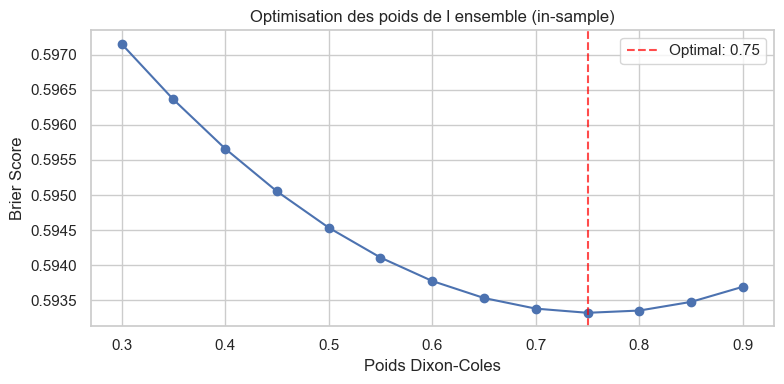

In [5]:
# Grid search sur les poids (in-sample)
best_brier = 1.0
best_w = 0.5
results = []

for w_dc in np.arange(0.3, 0.9, 0.05):
    w_elo = 1.0 - w_dc
    combined = dc_arr * w_dc + elo_arr * w_elo
    # Renormaliser
    combined = combined / combined.sum(axis=1, keepdims=True)
    bs = brier_score(combined, out_arr)
    results.append({'dc_weight': w_dc, 'elo_weight': w_elo, 'brier': bs})
    if bs < best_brier:
        best_brier = bs
        best_w = w_dc

df_w = pd.DataFrame(results)
print(f'Meilleur poids DC: {best_w:.2f} (Brier: {best_brier:.4f})')

plt.figure(figsize=(8, 4))
plt.plot(df_w['dc_weight'], df_w['brier'], 'o-')
plt.axvline(x=best_w, color='red', linestyle='--', alpha=0.7, label=f'Optimal: {best_w:.2f}')
plt.xlabel('Poids Dixon-Coles')
plt.ylabel('Brier Score')
plt.title('Optimisation des poids de l ensemble (in-sample)')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Diagramme de calibration

Quand on predit 70%, est-ce que ca arrive 70% du temps ?

2026-02-07 12:34:26.387 | INFO     | src.evaluation.calibration:evaluate:157 - [FAIL] Brier=0.5935 LogLoss=0.9920 ECE=0.0304 Accuracy=52.6% N=306


[FAIL] Brier=0.5935 LogLoss=0.9920 ECE=0.0304 Accuracy=52.6% N=306


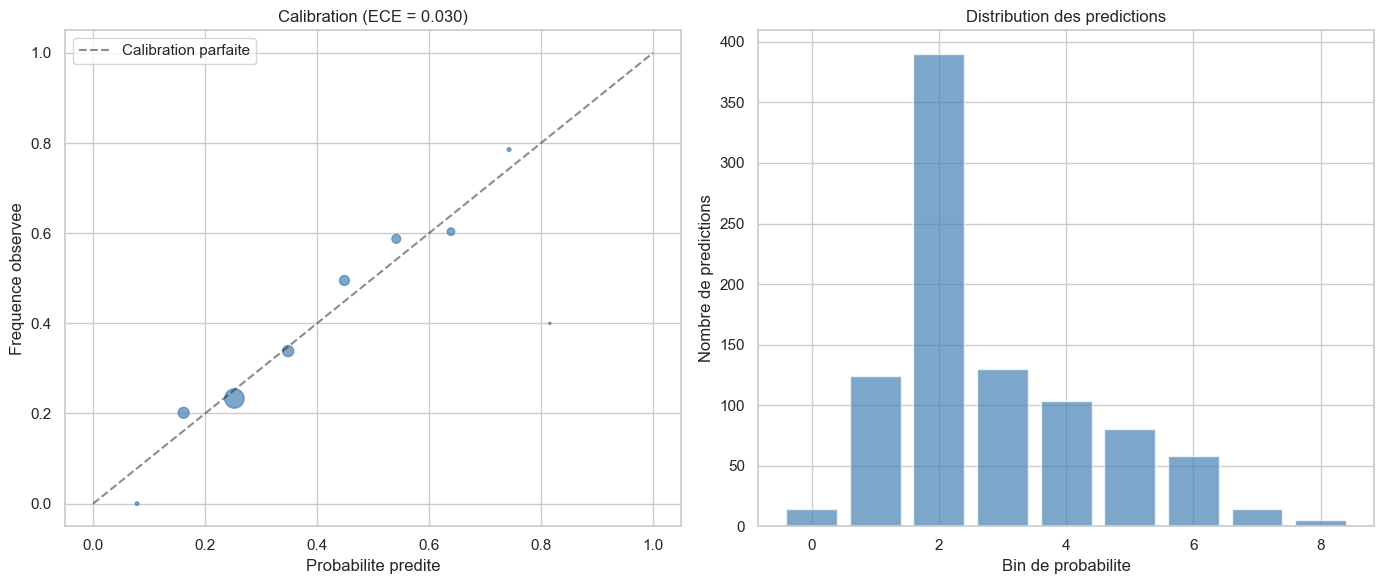

In [6]:
# Rapport complet de calibration pour l'ensemble
report = evaluate(ens_arr, out_arr)
print(report.summary())

# Diagramme
bins = report.calibration_bins
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Predicted vs Actual
preds = [b['avg_predicted'] for b in bins if b['count'] > 0]
actuals = [b['avg_actual'] for b in bins if b['count'] > 0]
counts = [b['count'] for b in bins if b['count'] > 0]

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Calibration parfaite')
ax1.scatter(preds, actuals, s=[c/2 for c in counts], alpha=0.7, c='steelblue')
ax1.set_xlabel('Probabilite predite')
ax1.set_ylabel('Frequence observee')
ax1.set_title(f'Calibration (ECE = {report.ece:.3f})')
ax1.legend()

# Distribution des predictions
ax2.bar(range(len(counts)), counts, color='steelblue', alpha=0.7)
ax2.set_xlabel('Bin de probabilite')
ax2.set_ylabel('Nombre de predictions')
ax2.set_title('Distribution des predictions')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'data' / 'results' / 'calibration_insample.png', dpi=150)
plt.show()

## Prochaine etape

L'ensemble est configure avec les poids optimaux. **Passons au notebook 05_backtest** pour la VRAIE validation walk-forward.